In [19]:
# import necessary libraries
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import pytz
import neurokit2 as nk


## 第一部分：EDA 数据清理与可视化
### 包括：
#### 1. EDA特征提取（neurokit2)
#### 2. normalization
#### 3. variability
#### 4. 数据可视化(html+png)



In [20]:
# ⭐⭐⭐ replace with your actual CSV file path
CSV_PATH = Path("test-user00/raw_eda.csv")

df = pd.read_csv(CSV_PATH, parse_dates=["timestamp"])

# ==== 基本配置（你必须有这一段） ====
FS = 5                   # Empatica EDA 采样率 5 Hz
EDA_COL = "eda_uS"       # 你的 CSV 里 EDA 所在的列名
TIME_COL = "timestamp"   # 时间戳列名
ACC_COLS = ["acc_x_g", "acc_y_g", "acc_z_g"]
LOCAL_TZ = "America/New_York"

df.head()

,timestamp,acc_x_g,acc_y_g,acc_z_g,eda_uS,temperature_c,bvp
0,2025-11-20 12:08:48.116990-05:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-11-20 12:08:48.120561-05:00,NaN,NaN,NaN,NaN,NaN,0.000000
2,2025-11-20 12:08:48.132615-05:00,-0.018544,-0.539728,0.837408,NaN,NaN,NaN
3,2025-11-20 12:08:48.136186-05:00,NaN,NaN,NaN,NaN,NaN,0.000009
4,2025-11-20 12:08:48.148231-05:00,-0.030256,-0.531432,0.832040,NaN,NaN,NaN


In [21]:
# ===== 1. 确保 timestamp 是 tz-aware，并转成本地时区 =====
# 统一先当成 UTC，再转 America/New_York

# 1) 把字符串 timestamp 解析成 datetime（会自动识别 "-05:00"）
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")

# 2) 建立本地时间列 timestamp_local
#    如果已经是 tz-aware，就 tz_convert；否则就 tz_localize
if pd.api.types.is_datetime64tz_dtype(df[TIME_COL].dtype):
    df["timestamp_local"] = df[TIME_COL].dt.tz_convert(LOCAL_TZ)
else:
    df["timestamp_local"] = df[TIME_COL].dt.tz_localize(LOCAL_TZ)

# ===== ⭐⭐⭐ 2. 在这里选择想看的时间段 =====

start_time = pd.Timestamp("2025-11-20 12:20:00", tz=LOCAL_TZ)
end_time = pd.Timestamp("2025-11-20 13:20:00", tz=LOCAL_TZ)


# ===== 3. 先按时间段截取原始 5Hz 数据 =====

mask = (df["timestamp_local"] >= start_time) & (df["timestamp_local"] <= end_time)
df_slice = df.loc[mask].copy().reset_index(drop=True)

print(f"Raw slice points: {len(df_slice)}")

# ===== 4.  Step 1: EDA preprocessing（NeuroKit2） =====

# 取出 EDA 列，并插值补 NaN
eda_raw = pd.to_numeric(df_slice["eda_uS"], errors="coerce")
eda_interp = eda_raw.interpolate(limit_direction="both")

# NeuroKit2 预处理 + SCL / SCR 分解
eda_signals, eda_info = nk.eda_process(eda_interp, sampling_rate=FS)

# 把 EDA_Clean / EDA_Tonic / EDA_Phasic 合并回 df_slice
df_slice_proc = pd.concat(
    [df_slice.reset_index(),   # 带 timestamp_local
     eda_signals[["EDA_Clean", "EDA_Tonic", "EDA_Phasic"]].reset_index(drop=True)],
    axis=1
)



# ===== 5. 为了画图更干净：把所有信号按 1 秒下采样 =====
df_downsampled = (
    df_slice_proc
      .set_index("timestamp_local")
      .resample("200ms")
      .mean()
      .dropna(how="all")
      .reset_index()
)


print(f"Downsampled points: {len(df_downsampled)}")
df_downsampled.head()


/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_16456/4050751065.py:9: DeprecationWarning:

is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.

/opt/anaconda3/envs/cs109a/lib/python3.12/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning:

EDA signal is sampled at very low frequency. Skipping filtering.



Raw slice points: 446296
Downsampled points: 16654


,timestamp_local,index,timestamp,acc_x_g,acc_y_g,acc_z_g,eda_uS,temperature_c,bvp,EDA_Clean,EDA_Tonic,EDA_Phasic
0,2025-11-20 12:20:00-05:00,12.5,2025-11-20 12:20:00.098852352-05:00,-0.449561,0.708501,0.363222,11.363670,NaN,0.021650,11.365517,11.366863,-0.001346
1,2025-11-20 12:20:00.200000-05:00,39.0,2025-11-20 12:20:00.299966720-05:00,-0.531282,0.791236,0.281651,11.375320,NaN,-0.059337,11.373457,11.371951,0.001506
2,2025-11-20 12:20:00.400000-05:00,66.0,2025-11-20 12:20:00.502667520-05:00,-0.535905,0.906379,0.297965,11.373894,NaN,-0.095342,11.374320,11.374209,0.000111
3,2025-11-20 12:20:00.600000-05:00,92.5,2025-11-20 12:20:00.697436672-05:00,-0.475950,0.893190,0.265960,NaN,NaN,-0.075735,11.373661,11.374213,-0.000552
4,2025-11-20 12:20:00.800000-05:00,119.5,2025-11-20 12:20:00.896779008-05:00,-0.479216,0.865337,0.233226,11.373427,31.84375,-0.008895,11.374858,11.375229,-0.000371


In [22]:
# ==== EDA z-score normalization & 导出 CSV ====

# 想要做 z-score 的列（可以按需增减）
eda_cols_to_norm = ["EDA_Clean", "EDA_Tonic", "EDA_Phasic"]

for col in eda_cols_to_norm:
    if col in df_downsampled.columns:
        mean_val = df_downsampled[col].mean()
        std_val  = df_downsampled[col].std()

        # 避免 std = 0 导致除零
        if std_val == 0 or pd.isna(std_val):
            print(f"[WARN] Column {col} has zero/NaN std, skip normalization.")
            continue

        z_col = col + "_z"  # 比如 EDA_Tonic_z
        df_downsampled[z_col] = (df_downsampled[col] - mean_val) / std_val
    else:
        print(f"[WARN] Column {col} not found in processed, skip.")

# 生成输出文件名：原文件名 + _eda_normalized.csv
output_csv_path = CSV_PATH.with_name(CSV_PATH.stem + "_eda_normalized.csv")

# 导出完整 processed（包含原始列 + z-score 列）
df_downsampled.to_csv(output_csv_path, index=False)

print(f"✅ EDA normalized CSV saved to: {output_csv_path}")
df_downsampled.head()


✅ EDA normalized CSV saved to: test-user00/raw_eda_eda_normalized.csv


,timestamp_local,index,timestamp,acc_x_g,acc_y_g,acc_z_g,eda_uS,temperature_c,bvp,EDA_Clean,EDA_Tonic,EDA_Phasic,EDA_Clean_z,EDA_Tonic_z,EDA_Phasic_z
0,2025-11-20 12:20:00-05:00,12.5,2025-11-20 12:20:00.098852352-05:00,-0.449561,0.708501,0.363222,11.363670,NaN,0.021650,11.365517,11.366863,-0.001346,1.164107,1.164400,-0.306614
1,2025-11-20 12:20:00.200000-05:00,39.0,2025-11-20 12:20:00.299966720-05:00,-0.531282,0.791236,0.281651,11.375320,NaN,-0.059337,11.373457,11.371951,0.001506,1.165823,1.165500,0.342460
2,2025-11-20 12:20:00.400000-05:00,66.0,2025-11-20 12:20:00.502667520-05:00,-0.535905,0.906379,0.297965,11.373894,NaN,-0.095342,11.374320,11.374209,0.000111,1.166009,1.165988,0.024863
3,2025-11-20 12:20:00.600000-05:00,92.5,2025-11-20 12:20:00.697436672-05:00,-0.475950,0.893190,0.265960,NaN,NaN,-0.075735,11.373661,11.374213,-0.000552,1.165867,1.165988,-0.126046
4,2025-11-20 12:20:00.800000-05:00,119.5,2025-11-20 12:20:00.896779008-05:00,-0.479216,0.865337,0.233226,11.373427,31.84375,-0.008895,11.374858,11.375229,-0.000371,1.166125,1.166208,-0.084853


In [23]:
# ==== Step: 计算 EDA Sliding-window variability (类似 HRV 的 EDAV) ====

# 采样率（如果上面已经有 FS / sampling_rate，可以直接用）
FS = 5  # 或直接 FS = 5

time_col = "timestamp"   # 如果你有 timestamp_local 就改成那个

# 窗口长度（秒）——可以自由改，比如 5、10、20 秒
WINDOW_SEC = 5
window_samples = max(int(WINDOW_SEC * FS), 1)

print(f"Using window = {WINDOW_SEC}s ({window_samples} samples) for sliding std.")

# 选择用哪一列来做 variability：优先用 z-score，方便不同人对比
if "EDA_Clean_z" in df_downsampled.columns:
    base_col = "EDA_Clean_z"
else:
    base_col = "EDA_Clean"

# 计算滚动标准差（滑动窗口变异度）
var_col_name = f"{base_col}_std_{WINDOW_SEC}s"
df_downsampled[var_col_name] = (
    df_downsampled[base_col]
    .rolling(window=window_samples, center=True)
    .std()
)

print(f"✅ Added variability column: {var_col_name}")

# 如需导出新的 CSV（可选）
output_csv_path = CSV_PATH.with_name(CSV_PATH.stem + f"_eda_with_variability_{WINDOW_SEC}s.csv")
df_downsampled.to_csv(output_csv_path, index=False)
print(f"💾 CSV with variability saved to: {output_csv_path}")
df_downsampled.head()


Using window = 5s (25 samples) for sliding std.
✅ Added variability column: EDA_Clean_z_std_5s
💾 CSV with variability saved to: test-user00/raw_eda_eda_with_variability_5s.csv


,timestamp_local,index,timestamp,acc_x_g,acc_y_g,acc_z_g,eda_uS,temperature_c,bvp,EDA_Clean,EDA_Tonic,EDA_Phasic,EDA_Clean_z,EDA_Tonic_z,EDA_Phasic_z,EDA_Clean_z_std_5s
0,2025-11-20 12:20:00-05:00,12.5,2025-11-20 12:20:00.098852352-05:00,-0.449561,0.708501,0.363222,11.363670,NaN,0.021650,11.365517,11.366863,-0.001346,1.164107,1.164400,-0.306614,NaN
1,2025-11-20 12:20:00.200000-05:00,39.0,2025-11-20 12:20:00.299966720-05:00,-0.531282,0.791236,0.281651,11.375320,NaN,-0.059337,11.373457,11.371951,0.001506,1.165823,1.165500,0.342460,NaN
2,2025-11-20 12:20:00.400000-05:00,66.0,2025-11-20 12:20:00.502667520-05:00,-0.535905,0.906379,0.297965,11.373894,NaN,-0.095342,11.374320,11.374209,0.000111,1.166009,1.165988,0.024863,NaN
3,2025-11-20 12:20:00.600000-05:00,92.5,2025-11-20 12:20:00.697436672-05:00,-0.475950,0.893190,0.265960,NaN,NaN,-0.075735,11.373661,11.374213,-0.000552,1.165867,1.165988,-0.126046,NaN
4,2025-11-20 12:20:00.800000-05:00,119.5,2025-11-20 12:20:00.896779008-05:00,-0.479216,0.865337,0.233226,11.373427,31.84375,-0.008895,11.374858,11.375229,-0.000371,1.166125,1.166208,-0.084853,NaN


In [25]:
# ==== EDA stacked HTML visualization ====

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import os
from pathlib import Path

TIME_COL = "timestamp_local"
df = df_downsampled.copy()
df["Time"] = pd.to_datetime(df[TIME_COL]).dt.tz_localize(None)

subject_name = CSV_PATH.stem

# ---- 全局时间范围 ----
global_start = df["Time"].min()
global_end   = df["Time"].max()

# 生成分钟刻度
start_minute = global_start.replace(second=0, microsecond=0)
end_minute   = global_end.replace(second=0, microsecond=0) + pd.Timedelta(minutes=1)

minute_ticks, minute_labels = [], []
cur = start_minute
while cur <= end_minute:
    minute_ticks.append(cur)
    minute_labels.append(cur.strftime("%H:%M"))
    cur += pd.Timedelta(minutes=1)

# ==== 创建 3 行 subplot（EDA） ====
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=[
        "EDA_Tonic_z",
        "EDA_Phasic_z",
        "EDA_Clean_z_std_5s",
    ],
)

# Row 1: EDA_Tonic_z
fig.add_trace(
    go.Scatter(
        x=df["Time"],
        y=df["EDA_Tonic_z"],
        mode="lines",
        name="EDA_Tonic_z",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>EDA_Tonic_z=%{y:.3f}<extra></extra>",
    ),
    row=1, col=1
)

# Row 2: EDA_Phasic_z
fig.add_trace(
    go.Scatter(
        x=df["Time"],
        y=df["EDA_Phasic_z"],
        mode="lines",
        name="EDA_Phasic_z",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>EDA_Phasic_z=%{y:.3f}<extra></extra>",
    ),
    row=2, col=1
)

# Row 3: EDA_Clean_z_std_5s
fig.add_trace(
    go.Scatter(
        x=df["Time"],
        y=df["EDA_Clean_z_std_5s"],
        mode="lines",
        name="EDA_Clean_z_std_5s",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>Std(5s)=%{y:.3f}<extra></extra>",
    ),
    row=3, col=1
)

# ---- Layout ----
fig.update_layout(
    title=dict(text=f"EDA Overview - {subject_name}", font=dict(size=18)),
    width=1400,
    height=3 * 350,
    hovermode="x unified",
    plot_bgcolor="white",
    paper_bgcolor="white",
    margin=dict(l=80, r=40, t=80, b=80),
)

# Y 轴标题
fig.update_yaxes(title_text="EDA_Tonic_z",       row=1, col=1, showgrid=True, gridcolor="#e0e0e0")
fig.update_yaxes(title_text="EDA_Phasic_z",      row=2, col=1, showgrid=True, gridcolor="#e0e0e0")
fig.update_yaxes(title_text="Std (z-score, 5s)", row=3, col=1, showgrid=True, gridcolor="#e0e0e0")

# X 轴：时间刻度
for r in range(1, 4):
    fig.update_xaxes(
        row=r, col=1,
        type="date",
        showgrid=True,
        gridcolor="#e0e0e0",
        tickmode="array",
        tickvals=minute_ticks,
        ticktext=minute_labels,
        tickangle=-45,
        tickformat="%H:%M",
        range=[global_start, global_end],
        showticklabels=True,
    )

fig.update_xaxes(title_text="Time (local)", row=3, col=1)

# ---- 保存 ----
out_dir = os.path.join(os.path.dirname(str(CSV_PATH)), "charts_eda")
os.makedirs(out_dir, exist_ok=True)

html_path = os.path.join(out_dir, f"{subject_name}_EDA_all_in_one.html")
png_path  = os.path.join(out_dir, f"{subject_name}_EDA_all_in_one.png")

fig.write_html(html_path, include_plotlyjs="cdn")
print(f"HTML saved: {html_path}")

try:
    fig.write_image(png_path, scale=2)
    print(f"PNG saved: {png_path}")
except Exception as e:
    print(f"[WARN] PNG not saved: {e}")

HTML saved: test-user00/charts_eda/raw_eda_EDA_all_in_one.html
[WARN] PNG not saved: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido



## 第二部分：Zephyr 呼吸数据清理与可视化

In [26]:
import pandas as pd
from pathlib import Path
import numpy as np

# ---- ⭐⭐⭐⭐⭐⭐ 读入 breathing 数据（如何这个participant没有收集到breathing data, 就跳过这个cell）----
BREATHING_CSV_PATH = Path("test-user00/Breathing.csv")      # 呼吸数据
br_df = pd.read_csv(BREATHING_CSV_PATH)

br_df["Time"] = pd.to_datetime(br_df["Time"])
br_df["Time"] = br_df["Time"].dt.tz_localize(None)   # 去掉 tz，方便和 EDA 对齐

# ---- 估计采样率（Hz）：用相邻时间差的中位数反推 ----
dt_median = br_df["Time"].sort_values().diff().dt.total_seconds().median()
fs_br = 1.0 / dt_median
print(f"Estimated breathing sampling rate: {fs_br:.2f} Hz")

# ---- 定义窗口长度（秒）----
WINDOW_AMP_SEC = 5   # 计算振幅的窗口长度（可改，例如 5s / 10s）
WINDOW_VAR_SEC = 30  # 计算变异度的窗口长度（类似 30s HRV）

win_amp_samples = max(int(WINDOW_AMP_SEC * fs_br), 1)
win_var_samples = max(int(WINDOW_VAR_SEC * fs_br), 1)

print(f"Amplitude window: {win_amp_samples} samples ({WINDOW_AMP_SEC}s)")
print(f"Variability window: {win_var_samples} samples ({WINDOW_VAR_SEC}s)")

# ---- 1) 振幅：窗口内 max - min ----
def peak_to_peak(x):
    return np.max(x) - np.min(x)

br_df["BR_Amplitude"] = (
    br_df["BreathingWaveform"]
    .rolling(win_amp_samples, center=True)
    .apply(peak_to_peak, raw=True)
)

# ---- 2) 变异度：振幅的滚动 std（类似“呼吸深度的变异性”）----
br_df["BR_Variability"] = (
    br_df["BR_Amplitude"]
    .rolling(win_var_samples, center=True)
    .std()
)

# 可选：导出带特征的 breathing CSV 备用
breathing_out = BREATHING_CSV_PATH.with_name(BREATHING_CSV_PATH.stem + "_with_features.csv")
br_df.to_csv(breathing_out, index=False)
print(f"✅ Breathing features saved to: {breathing_out}")
br_df.head()


/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_16456/2357335994.py:9: UserWarning:

Parsing dates in %d/%m/%Y %H:%M:%S.%f format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



Estimated breathing sampling rate: 25.00 Hz
Amplitude window: 125 samples (5s)
Variability window: 750 samples (30s)
✅ Breathing features saved to: test-user00/Breathing_with_features.csv


,Time,BreathingWaveform,BR_Amplitude,BR_Variability
0,2025-11-20 12:05:33.409,6988817,NaN,NaN
1,2025-11-20 12:05:33.449,7027786,NaN,NaN
2,2025-11-20 12:05:33.489,7027786,NaN,NaN
3,2025-11-20 12:05:33.529,6997986,NaN,NaN
4,2025-11-20 12:05:33.569,6997986,NaN,NaN


In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from pathlib import Path
import os

# ---- 基本输入 ----
TIME_COL_EDA   = "timestamp_local"

eda_df = df_downsampled.copy()
eda_df["Time"] = pd.to_datetime(eda_df[TIME_COL_EDA]).dt.tz_localize(None)

# br_df 已在上一步创建，确保 Time 无时区
br_df["Time"] = pd.to_datetime(br_df["Time"]).dt.tz_localize(None)

subject_name = CSV_PATH.stem

# ---- 全局时间范围 ----
global_start = min(eda_df["Time"].min(), br_df["Time"].min())
global_end   = max(eda_df["Time"].max(), br_df["Time"].max())

# 分钟刻度
start_minute = global_start.replace(second=0, microsecond=0)
end_minute   = global_end.replace(second=0, microsecond=0) + pd.Timedelta(minutes=1)

minute_ticks, minute_labels = [], []
cur = start_minute
while cur <= end_minute:
    minute_ticks.append(cur)
    minute_labels.append(cur.strftime("%H:%M"))
    cur += pd.Timedelta(minutes=1)

# ---- 5 行 subplot：3 个 EDA + 2 个 breathing ----
fig = make_subplots(
    rows=5,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=[
        "EDA_SCL (normalized)",
        "EDA_SCR (normalized)",
        "EDA_Variability (5s window)",
        "Breathing Amplitude ({}s window)".format(WINDOW_AMP_SEC),
        "Breathing Variability ({}s window)".format(WINDOW_VAR_SEC),
    ],
)

# Row 1: EDA_Tonic_z
fig.add_trace(
    go.Scatter(
        x=eda_df["Time"],
        y=eda_df["EDA_Tonic_z"],
        mode="lines",
        name="EDA_SCL (normalized)",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>EDA_Tonic_z=%{y:.3f}<extra></extra>",
    ),
    row=1, col=1
)

# Row 2: EDA_Phasic_z
fig.add_trace(
    go.Scatter(
        x=eda_df["Time"],
        y=eda_df["EDA_Phasic_z"],
        mode="lines",
        name="EDA_SCR (normalized)",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>EDA_Phasic_z=%{y:.3f}<extra></extra>",
    ),
    row=2, col=1
)

# Row 3: EDA_Clean_z_std_5s
fig.add_trace(
    go.Scatter(
        x=eda_df["Time"],
        y=eda_df["EDA_Clean_z_std_5s"],
        mode="lines",
        name="EDA_Variability (5s window)",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>Std(5s)=%{y:.3f}<extra></extra>",
    ),
    row=3, col=1
)

# Row 4: amplitude
fig.add_trace(
    go.Scatter(
        x=br_df["Time"],
        y=br_df["BR_Amplitude"],
        mode="lines",
        name="BR_Amplitude",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>Amp=%{y:.2f}<extra></extra>",
    ),
    row=4, col=1
)

# Row 5: variability
fig.add_trace(
    go.Scatter(
        x=br_df["Time"],
        y=br_df["BR_Variability"],
        mode="lines",
        name="BR_Variability",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>Var=%{y:.2f}<extra></extra>",
    ),
    row=5, col=1
)

# ---- Layout & axes ----
fig.update_layout(
    title=dict(text=f"EDA + Breathing (Amplitude & Variability) - {subject_name}", font=dict(size=18)),
    width=1700,
    height=5 * 320,
    hovermode="x unified",
    plot_bgcolor="white",
    paper_bgcolor="white",
    margin=dict(l=80, r=40, t=80, b=80),
)

y_titles = [
    "z-score (tonic)",
    "z-score (phasic)",
    "Std (z-score)",
    "Amplitude",
    "Variability",
]
for r, ylab in enumerate(y_titles, start=1):
    fig.update_yaxes(title_text=ylab, row=r, col=1, showgrid=True, gridcolor="#e0e0e0")

for r in range(1, 6):   # 5 行 subplot
    fig.update_xaxes(
        row=r,
        col=1,
        type="date",
        showgrid=True,
        gridcolor="#e0e0e0",
        tickmode="array",
        tickvals=minute_ticks,
        ticktext=minute_labels,
        tickformat="%H:%M",
        tickangle=-45,
        range=[global_start, global_end],
        showticklabels=True,
    )

# 只在最后一行加 x 轴标题
fig.update_xaxes(title_text="Time (local)", row=5, col=1)

# ---- 保存 ----
out_dir = os.path.join(os.path.dirname(str(CSV_PATH)), "charts_combined")
os.makedirs(out_dir, exist_ok=True)

html_path = os.path.join(out_dir, f"{subject_name}_Breathing_EDA_full.html")
png_path  = os.path.join(out_dir, f"{subject_name}_Breathing_EDA_full.png")

fig.write_html(html_path, include_plotlyjs="cdn")
print(f"HTML saved: {html_path}")

try:
    fig.write_image(png_path, scale=2)
    print(f"PNG saved: {png_path}")
except Exception as e:
    print(f"[WARN] PNG not saved: {e}")

HTML saved: test-user00/charts_combined/raw_eda_Breathing_EDA_full.html
[WARN] PNG not saved: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido



/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_16456/3745689734.py:13: DtypeWarning:

Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.



Original shape: (145100, 43)
Column names: ['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'PPG_Ambient', 'PPG_IR', 'PPG_Red', 'Heart_Rate', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery', 'Elements']
After removing empty rows: (145100, 43)
EEG signal length: 145080
Downsampled signal length: 14508
✅ Bandpass filtering applied
✅ Frequency band analysis completed
✅ Brain waves plot saved to: test-user00/charts_eeg/EEG_brain_waves.png


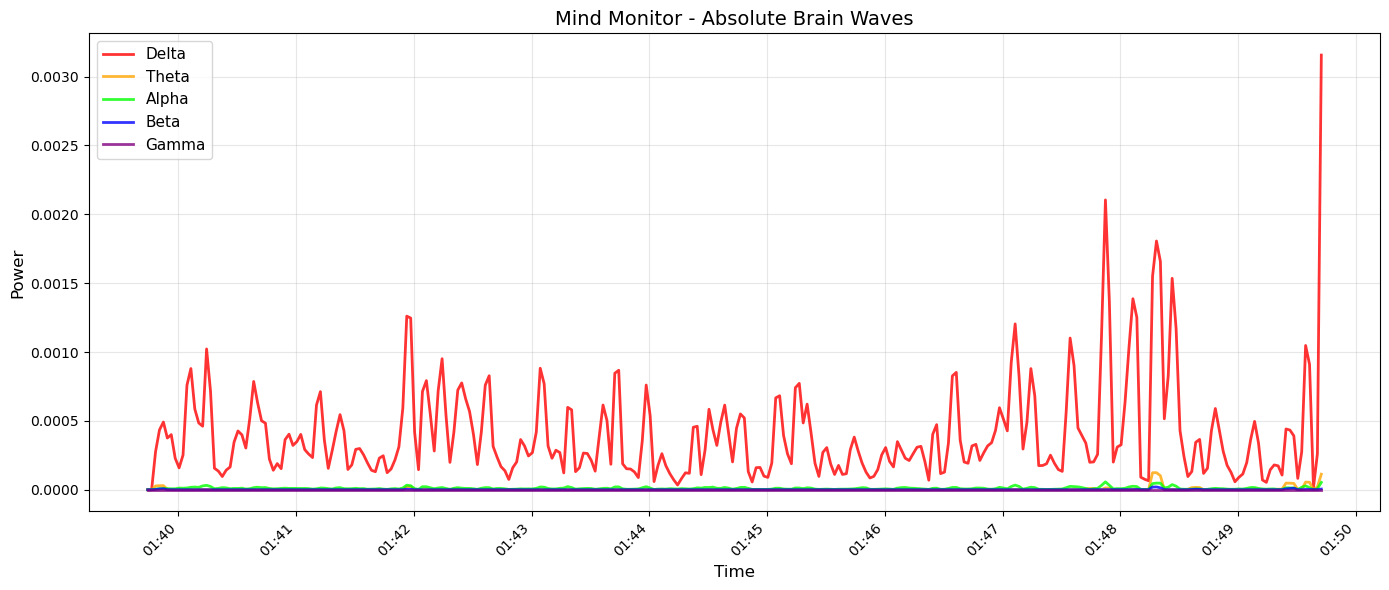

✅ Processed EEG data saved to: test-user00/mindMonitor_processed.csv

Data preview:
                           Time         Delta         Theta         Alpha  \
0 2026-02-16 01:39:44.397666666  3.761387e-09  7.340481e-14  5.796646e-09   
1 2026-02-16 01:39:46.397666666  4.779308e-07  4.935918e-12  6.030041e-09   
2 2026-02-16 01:39:48.397666666  2.764114e-04  2.729647e-05  4.325040e-06   
3 2026-02-16 01:39:50.397666666  4.343276e-04  2.913923e-05  7.412068e-06   
4 2026-02-16 01:39:52.397666666  4.916609e-04  2.965033e-05  9.323894e-06   

           Beta  Gamma  
0  1.156515e-07    0.0  
1  1.203551e-07    0.0  
2  2.010423e-06    0.0  
3  5.569239e-06    0.0  
4  6.704019e-06    0.0  


In [39]:
## 第三部分：脑电波（EEG）数据处理与可视化

import pandas as pd
import numpy as np
from pathlib import Path
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# ---- 1. 读取脑电波数据 ----
MINDMONITOR_CSV_PATH = Path("test-user00/mindMonitor_2026-02-16--01-39-41.csv")
eeg_df = pd.read_csv(MINDMONITOR_CSV_PATH)

print(f"Original shape: {eeg_df.shape}")
print(f"Column names: {eeg_df.columns.tolist()}")

# ---- 2. 去除空行 ----
eeg_df = eeg_df.dropna(how='all')
eeg_df = eeg_df.reset_index(drop=True)
print(f"After removing empty rows: {eeg_df.shape}")

# ---- 3. 时间列处理 ----
time_col = eeg_df.columns[0]
eeg_df['Time'] = pd.to_datetime(eeg_df[time_col], errors='coerce')
eeg_df = eeg_df.dropna(subset=['Time'])

# 采样率设置
ORIGINAL_FS = 256  # 原始采样率
TARGET_FS = 24     # 目标采样率
DOWNSAMPLE_FACTOR = ORIGINAL_FS // TARGET_FS

# ---- 4. 提取脑电波数据 ----
eeg_cols = [col for col in eeg_df.columns if col != time_col and col != 'Time']
if len(eeg_cols) > 0:
    eeg_signal_col = eeg_cols[0]
    eeg_signal = pd.to_numeric(eeg_df[eeg_signal_col], errors='coerce').dropna().values
else:
    raise ValueError("No EEG signal columns found!")

print(f"EEG signal length: {len(eeg_signal)}")

# ---- 5. 降采样 ----
n_samples = len(eeg_signal) // DOWNSAMPLE_FACTOR
eeg_downsampled = eeg_signal[:n_samples * DOWNSAMPLE_FACTOR].reshape(n_samples, DOWNSAMPLE_FACTOR).mean(axis=1)
eeg_time_original = eeg_df['Time'].values[:len(eeg_signal)]
eeg_time_downsampled = eeg_time_original[::DOWNSAMPLE_FACTOR][:len(eeg_downsampled)]

print(f"Downsampled signal length: {len(eeg_downsampled)}")

# ---- 6. 带通滤波 ----
def apply_bandpass_filter(signal_data, lowcut=0.5, highcut=50, fs=24, order=4):
    """带通滤波，带长度检查"""
    signal_len = len(signal_data)
    min_len_needed = 3 * (order + 1)
    
    if signal_len <= min_len_needed:
        print(f"[WARN] Signal too short ({signal_len}). Skipping filter.")
        return signal_data
    
    try:
        nyquist = fs / 2
        low = max(lowcut / nyquist, 0.001)
        high = min(highcut / nyquist, 0.999)
        b, a = signal.butter(order, [low, high], btype='band')
        filtered = signal.filtfilt(b, a, signal_data)
        return filtered
    except Exception as e:
        print(f"[WARN] Filtering failed: {e}. Using unfiltered signal.")
        return signal_data

eeg_filtered = apply_bandpass_filter(eeg_downsampled, lowcut=0.5, highcut=50, fs=TARGET_FS, order=4)
print("✅ Bandpass filtering applied")

# ---- 7. 频率分析 ----
def compute_frequency_bands(signal_data, fs=24):
    """计算各频段功率随时间的变化"""
    signal_len = len(signal_data)
    nperseg = min(128, signal_len // 2)
    noverlap = max(0, nperseg - fs * 2)
    
    if signal_len < nperseg:
        nperseg = max(16, signal_len // 2)
        noverlap = max(0, nperseg // 4)
    
    frequencies, times, Sxx = signal.spectrogram(
        signal_data, fs=fs, nperseg=nperseg, noverlap=noverlap
    )
    
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 50)
    }
    
    band_power = {}
    for band_name, (fmin, fmax) in bands.items():
        mask = (frequencies >= fmin) & (frequencies <= fmax)
        if mask.sum() > 0:
            band_power[band_name] = Sxx[mask, :].mean(axis=0)
        else:
            band_power[band_name] = np.zeros(Sxx.shape[1])
    
    return times, band_power, bands

times, band_power, bands = compute_frequency_bands(eeg_filtered, fs=TARGET_FS)
print("✅ Frequency band analysis completed")

# ---- 8. 转换时间戳为时间序列 ----
# 根据 spectrogram 返回的 times（秒），计算对应的日期时间
time_base = eeg_time_downsampled[0]
time_series = [time_base + pd.Timedelta(seconds=t) for t in times]

# ---- 9. 绘制结果图 ----
band_colors = {
    'Delta': '#FF0000',      # 红
    'Theta': '#FFA500',      # 橙
    'Alpha': '#00FF00',      # 绿
    'Beta': '#0000FF',       # 蓝
    'Gamma': '#800080'       # 紫
}

fig, ax = plt.subplots(figsize=(14, 6))

for band_name in ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']:
    ax.plot(time_series, band_power[band_name], 
            label=band_name, color=band_colors[band_name], linewidth=2, alpha=0.8)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Power', fontsize=12)
ax.set_title('Mind Monitor - Absolute Brain Waves', fontsize=14)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# 格式化 x 轴时间显示
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

# ---- 10. 保存图表 ----
out_dir = os.path.join(os.path.dirname(str(CSV_PATH)), "charts_eeg")
os.makedirs(out_dir, exist_ok=True)

png_path = os.path.join(out_dir, "EEG_brain_waves.png")
fig.savefig(png_path, dpi=150, bbox_inches='tight')
print(f"✅ Brain waves plot saved to: {png_path}")

plt.show()

# ---- 11. 导出处理后的数据 ----
eeg_export = pd.DataFrame({
    'Time': time_series,
    'Delta': band_power['Delta'],
    'Theta': band_power['Theta'],
    'Alpha': band_power['Alpha'],
    'Beta': band_power['Beta'],
    'Gamma': band_power['Gamma'],
})

export_path = Path(os.path.dirname(str(CSV_PATH))) / "mindMonitor_processed.csv"
eeg_export.to_csv(export_path, index=False)
print(f"✅ Processed EEG data saved to: {export_path}")
print(f"\nData preview:\n{eeg_export.head()}")

## 第四部分: 条件对比（scent vs no-scent）
### 包括：
#### 1. 按 phase 提取数据： drive_scent/no-scent
#### 2. 计算 summary features
#### 3. 做统计检验(significance)

In [42]:
import pandas as pd
import numpy as np
from pathlib import Path

# ========= 1. 时间标准化：统一成 tz-naive =========

# 1) EDA 时间列：从 processed 里拿 timestamp_local，去掉时区
eda_df = df_downsampled.copy()
eda_df["Time"] = (
    eda_df["timestamp_local"]
    .astype(str)        # 例如 "2025-11-20 12:12:25-05:00"
    .str.slice(0, 19)   # 只保留 "YYYY-MM-DD HH:MM:SS"
)
eda_df["Time"] = pd.to_datetime(eda_df["Time"])  # tz-naive

# 2) Breathing 时间列：如果也有时区，同样处理
br_df["Time"] = (
    br_df["Time"]
    .astype(str)
    .str.slice(0, 19)
)
br_df["Time"] = pd.to_datetime(br_df["Time"])    # tz-naive

print("EDA Time range:", eda_df["Time"].min(), "→", eda_df["Time"].max())
print("BR  Time range:", br_df["Time"].min(), "→", br_df["Time"].max())

# ========= 2. 手动定义两个条件的时间范围 =========

# ⭐⭐⭐ 修改这里来设置 drive_scent 和 drive_no_scent 的时间段
drive_scent_start = pd.Timestamp("2025-11-20 12:20:00")
drive_scent_end = pd.Timestamp("2025-11-20 12:40:00")

drive_no_scent_start = pd.Timestamp("2025-11-20 13:00:00")
drive_no_scent_end = pd.Timestamp("2025-11-20 13:20:00")

print("\nTime ranges:")
print(f"drive_scent:    {drive_scent_start} → {drive_scent_end}")
print(f"drive_no_scent: {drive_no_scent_start} → {drive_no_scent_end}")

# ========= 3. 从两个数据源中按时间段截取对应数据 =========

# EDA + Breathing 合并（按时间对齐）
df = pd.merge_asof(
    eda_df.sort_values("Time"),
    br_df.sort_values("Time"),
    on="Time",
    direction="nearest",
    tolerance=pd.Timedelta(seconds=1)
)

# ========= 4. 为每一行打上标签 =========

def assign_condition(t):
    """为每个时间点分配条件标签"""
    if drive_scent_start <= t <= drive_scent_end:
        return "drive_scent"
    elif drive_no_scent_start <= t <= drive_no_scent_end:
        return "drive_no_scent"
    else:
        return None

df["condition"] = df["Time"].apply(assign_condition)

# 筛选出有标签的数据（去掉时间范围外的行）
df_labeled = df[df["condition"].notna()].copy()

print("\nCondition value counts:")
print(df_labeled["condition"].value_counts())
print(f"\nTotal labeled samples: {len(df_labeled)}")

df_labeled.head()

EDA Time range: 2025-11-20 12:20:00 → 2025-11-20 13:19:32
BR  Time range: 2025-11-20 12:05:33 → 2025-11-20 13:14:39

Time ranges:
drive_scent:    2025-11-20 12:20:00 → 2025-11-20 12:40:00
drive_no_scent: 2025-11-20 13:00:00 → 2025-11-20 13:20:00

Condition value counts:
condition
drive_scent       6005
drive_no_scent    4654
Name: count, dtype: int64

Total labeled samples: 10659


,timestamp_local,index,timestamp,acc_x_g,acc_y_g,acc_z_g,eda_uS,temperature_c,bvp,EDA_Clean,...,EDA_Phasic,EDA_Clean_z,EDA_Tonic_z,EDA_Phasic_z,EDA_Clean_z_std_5s,Time,BreathingWaveform,BR_Amplitude,BR_Variability,condition
0,2025-11-20 12:20:00-05:00,12.5,2025-11-20 12:20:00.098852352-05:00,-0.449561,0.708501,0.363222,11.363670,NaN,0.021650,11.365517,...,-0.001346,1.164107,1.164400,-0.306614,NaN,2025-11-20 12:20:00,7328640.0,18644.0,6600.964455,drive_scent
1,2025-11-20 12:20:00.200000-05:00,39.0,2025-11-20 12:20:00.299966720-05:00,-0.531282,0.791236,0.281651,11.375320,NaN,-0.059337,11.373457,...,0.001506,1.165823,1.165500,0.342460,NaN,2025-11-20 12:20:00,7328640.0,18644.0,6600.964455,drive_scent
2,2025-11-20 12:20:00.400000-05:00,66.0,2025-11-20 12:20:00.502667520-05:00,-0.535905,0.906379,0.297965,11.373894,NaN,-0.095342,11.374320,...,0.000111,1.166009,1.165988,0.024863,NaN,2025-11-20 12:20:00,7328640.0,18644.0,6600.964455,drive_scent
3,2025-11-20 12:20:00.600000-05:00,92.5,2025-11-20 12:20:00.697436672-05:00,-0.475950,0.893190,0.265960,NaN,NaN,-0.075735,11.373661,...,-0.000552,1.165867,1.165988,-0.126046,NaN,2025-11-20 12:20:00,7328640.0,18644.0,6600.964455,drive_scent
4,2025-11-20 12:20:00.800000-05:00,119.5,2025-11-20 12:20:00.896779008-05:00,-0.479216,0.865337,0.233226,11.373427,31.84375,-0.008895,11.374858,...,-0.000371,1.166125,1.166208,-0.084853,NaN,2025-11-20 12:20:00,7328640.0,18644.0,6600.964455,drive_scent


In [43]:
def summarize(block, name):
    """计算条件下的统计特征"""
    print(f"\n=== Summary: {name}  (N = {len(block)}) ===")
    if block is None or len(block) == 0:
        print("  -> No samples in this condition.")
        return None

    stats = {
        "condition": name,
        "n_samples": len(block),
        "EDA_Tonic_z_mean": block["EDA_Tonic_z"].mean(),
        "EDA_Tonic_z_std": block["EDA_Tonic_z"].std(),
        "EDA_Phasic_z_mean": block["EDA_Phasic_z"].mean(),
        "EDA_Phasic_z_std": block["EDA_Phasic_z"].std(),
        "EDA_var_5s_mean": block["EDA_Clean_z_std_5s"].mean(),
        "BR_amp_mean": block["BR_Amplitude"].mean(),
        "BR_amp_std": block["BR_Amplitude"].std(),
        "BR_var_mean": block["BR_Variability"].mean(),
        "BR_var_std": block["BR_Variability"].std(),
    }

    df_stats = pd.DataFrame([stats])
    print(df_stats.round(3))
    return df_stats

# 从标记好的数据中提取两个条件
drive_scent_df = df_labeled[df_labeled["condition"] == "drive_scent"]
drive_noscent_df = df_labeled[df_labeled["condition"] == "drive_no_scent"]

# 计算统计特征
summary_drive_scent = summarize(drive_scent_df, "drive_scent")
summary_drive_noscent = summarize(drive_noscent_df, "drive_no_scent")

# 合并结果（可选，方便对比）
summary_all = pd.concat(
    [summary_drive_scent, summary_drive_noscent],
    ignore_index=True
)
print("\n=== Summary Comparison ===")
print(summary_all.to_string())


=== Summary: drive_scent  (N = 6005) ===
     condition  n_samples  EDA_Tonic_z_mean  EDA_Tonic_z_std  \
0  drive_scent       6005             0.678            1.371   

   EDA_Phasic_z_mean  EDA_Phasic_z_std  EDA_var_5s_mean  BR_amp_mean  \
0               -0.0             0.527            0.008   472541.714   

    BR_amp_std  BR_var_mean  BR_var_std  
0  1142176.737   549359.908  687339.071  

=== Summary: drive_no_scent  (N = 4654) ===
        condition  n_samples  EDA_Tonic_z_mean  EDA_Tonic_z_std  \
0  drive_no_scent       4654            -0.176              0.3   

   EDA_Phasic_z_mean  EDA_Phasic_z_std  EDA_var_5s_mean  BR_amp_mean  \
0               -0.0             1.101            0.012   598649.461   

    BR_amp_std  BR_var_mean  BR_var_std  
0  1273283.265   799511.346  737821.144  

=== Summary Comparison ===
        condition  n_samples  EDA_Tonic_z_mean  EDA_Tonic_z_std  EDA_Phasic_z_mean  EDA_Phasic_z_std  EDA_var_5s_mean    BR_amp_mean    BR_amp_std    BR_var_mean  

In [44]:
from scipy.stats import mannwhitneyu

def compare_conditions(df1, df2, metric, name1, name2):
    """对两个条件进行 Mann-Whitney U 检验"""
    x = df1[metric].dropna()
    y = df2[metric].dropna()
    
    if len(x) == 0 or len(y) == 0:
        print(f"\n--- {metric}: {name1} vs {name2} ---")
        print("⚠️  Insufficient data for comparison")
        return None
    
    stat, p = mannwhitneyu(x, y, alternative='two-sided')
    print(f"\n--- {metric}: {name1} vs {name2} ---")
    print(f"  n1={len(x)}, n2={len(y)}")
    print(f"  {name1} mean={x.mean():.4f} ± {x.std():.4f}")
    print(f"  {name2} mean={y.mean():.4f} ± {y.std():.4f}")
    print(f"  U={stat:.2f}, p={p:.5f}")
    if p < 0.05:
        print("  → Significant difference ✔")
    else:
        print("  → Not significant ✘")
    return p

# 对比 drive_scent vs drive_no_scent 的各个指标
print("="*60)
print("Statistical Comparison: drive_scent vs drive_no_scent")
print("="*60)

compare_conditions(drive_scent_df, drive_noscent_df, "EDA_Tonic_z", "drive_scent", "drive_no_scent")
compare_conditions(drive_scent_df, drive_noscent_df, "EDA_Phasic_z", "drive_scent", "drive_no_scent")
compare_conditions(drive_scent_df, drive_noscent_df, "EDA_Clean_z_std_5s", "drive_scent", "drive_no_scent")
compare_conditions(drive_scent_df, drive_noscent_df, "BR_Amplitude", "drive_scent", "drive_no_scent")
compare_conditions(drive_scent_df, drive_noscent_df, "BR_Variability", "drive_scent", "drive_no_scent")

Statistical Comparison: drive_scent vs drive_no_scent

--- EDA_Tonic_z: drive_scent vs drive_no_scent ---
  n1=6005, n2=4654
  drive_scent mean=0.6783 ± 1.3707
  drive_no_scent mean=-0.1758 ± 0.2998
  U=18090320.00, p=0.00000
  → Significant difference ✔

--- EDA_Phasic_z: drive_scent vs drive_no_scent ---
  n1=6005, n2=4654
  drive_scent mean=-0.0002 ± 0.5266
  drive_no_scent mean=-0.0003 ± 1.1010
  U=14037023.00, p=0.68747
  → Not significant ✘

--- EDA_Clean_z_std_5s: drive_scent vs drive_no_scent ---
  n1=5993, n2=4642
  drive_scent mean=0.0081 ± 0.0272
  drive_no_scent mean=0.0122 ± 0.0271
  U=10202781.00, p=0.00000
  → Significant difference ✔

--- BR_Amplitude: drive_scent vs drive_no_scent ---
  n1=6005, n2=4385
  drive_scent mean=472541.7144 ± 1142176.7367
  drive_no_scent mean=598649.4607 ± 1273283.2647
  U=10877212.50, p=0.00000
  → Significant difference ✔

--- BR_Variability: drive_scent vs drive_no_scent ---
  n1=6005, n2=4310
  drive_scent mean=549359.9082 ± 687339.0711


np.float64(3.5185979012488983e-19)